In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os
import torch
import torch.nn as nn
import os
import torchvision as tv
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import time
import copy
from torch.optim import Adam
plt.ion()  

In [2]:
use_gpu = 0
if use_gpu:
    torch.cuda.set_device(CUDA_DEVICE)

count=0

In [3]:
data_transform = {
    'Train' : tv.transforms.Compose([
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomVerticalFlip(),
        transforms.Resize(256),
        #transforms.RandomResizedCrop(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ]),
    'Val' : tv.transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ]),
    'Test' : tv.transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ])
        
}

In [4]:
data_folder = "../dataset"
datasets = ['Train','Val','Test']
image_data = {}
for x in datasets:
    image_data[x] = tv.datasets.ImageFolder(data_folder+'/'+x, transform=data_transform[x])
    
dset_sizes = {x: len(image_data[x]) for x in datasets}

In [5]:
data_loader = {}
for x in datasets:
    data_loader[x] = torch.utils.data.DataLoader(image_data[x], batch_size=32,
        shuffle=True, num_workers=4
    )
class_names = image_data['Train'].classes
print(class_names)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [6]:
def train_model(model, criterion, optimizer, lr_scheduler, num_epochs=100):
    since = time.time()

    best_model = model
    best_acc = 0.0
    store_train_loss = []
    store_train_acc = []
    store_val_loss = []
    store_val_acc = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Val']:
            if phase == 'train':
                mode='train'
                optimizer = lr_scheduler(optimizer, epoch)
                model.train()  # Set model to training mode
            else:
                model.eval()
                mode='val'

            running_loss = 0.0
            running_corrects = 0

            counter=0
            # Iterate over data.
            for data in data_loader[phase]:
                inputs, labels = data
                show_databatch(inputs, labels)
                #print(inputs.size())
                # wrap them in Variable
                if use_gpu:
                    try:
                        inputs, labels = Variable(inputs.float().cuda()),                             
                        Variable(labels.long().cuda())
                    except:
                        print(inputs,labels)
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # Set gradient to zero to delete history of computations in previous epoch. Track operations so that differentiation can be done automatically.
                optimizer.zero_grad()
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                
                loss = criterion(outputs, labels)
                # print('loss done')                
                # Just so that you can keep track that something's happening and don't feel like the program isn't running.
                # if counter%10==0:
                #     print("Reached iteration ",counter)
                counter+=1

                # backward + optimize only if in training phase
                if phase == 'Train':
                    # print('loss backward')
                    loss.backward()
                    # print('done loss backward')
                    optimizer.step()
                    # print('done optim')
                # print evaluation statistics
                try:
                    # running_loss += loss.data[0]
                    running_loss += loss.item()
                    # print(labels.data)
                    # print(preds)
                    running_corrects += torch.sum(preds == labels.data)
                    # print('running correct =',running_corrects)
                except:
                    print('unexpected error, could not calculate loss or do a sum.')
            print('trying epoch loss')
            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects.item() / float(dset_sizes[phase])
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 'Train':
                store_train_loss.append(epoch_loss)
                store_train_acc.append(epoch_acc)
            elif phase == 'Val':
                store_val_loss.append(epoch_loss)
                store_val_acc.append(epoch_acc)


            # deep copy the model
            if phase == 'Val':
                #if USE_TENSORBOARD:
                #    foo.add_scalar_value('epoch_loss',epoch_loss,step=epoch)
                #    foo.add_scalar_value('epoch_acc',epoch_acc,step=epoch)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model = copy.deepcopy(model)
                    print('new best accuracy = ',best_acc)
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('returning and looping back')
    return best_model

# This function changes the learning rate over the training model.
def exp_lr_scheduler(optimizer, epoch, init_lr=0.01, lr_decay_epoch=1):
    """Decay learning rate by a factor of DECAY_WEIGHT every lr_decay_epoch epochs."""
    lr = init_lr * (1**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

model_ft = models.alexnet(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False
num_features = model_ft.classifier[6].in_features
features = list(model_ft.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 4 outputs
model_ft.classifier = nn.Sequential(*features) 


criterion = nn.CrossEntropyLoss()

if use_gpu:
    criterion.cuda()
    model_ft.cuda()

optimizer_ft = optim.RMSprop(model_ft.parameters(), lr=0.0001)



# Run the functions and save the best model in the function model_ft.
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

# Save model
#model_ft.state_dict('fine_tuned_best_model.pt')
#model_ft.state_dict('mytraining.pt')


KeyboardInterrupt: 

In [7]:
model_ft.eval()
#torch.save(model_ft.state_dict(), 'mytraining_hf1.pt') 

NameError: name 'model_ft' is not defined

In [8]:
def test(m):
    print(type(m))
    test_acc = 0.0
    for i, (images, labels) in enumerate(data_loader['Test']):

#         if cuda_avail:
#             images = Variable(images.cuda())
#             labels = Variable(labels.cuda())

        # Predict classes using images from the test set
        outputs = m(images)
        _, prediction = torch.max(outputs.data, 1)
        print(prediction)
        print(labels.data)
        
        test_acc += torch.sum(prediction == labels.data)

    # Compute the average acc and loss over all 10000 test images
    test_acc = test_acc.item() / dset_sizes['Test']
    print(dset_sizes['Train'],dset_sizes['Val'],dset_sizes['Test'])
    return test_acc

In [9]:
model = models.alexnet(pretrained=True)
num_features = model.classifier[6].in_features
features = list(model.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 4 outputs
model.classifier = nn.Sequential(*features) 
model.load_state_dict(torch.load('mytraining_hf1.pt'))
model.eval()
acc = test(model)
print((acc))

<class 'torchvision.models.alexnet.AlexNet'>
tensor([ 3,  0,  8, 13, 21,  1, 18, 22, 10, 15, 23, 25, 14,  4, 19,  9, 11, 28,
        15, 27, 20,  5,  2,  6, 17, 24, 13,  7])
tensor([ 3,  0,  8, 13, 21,  1, 18, 22, 10, 15, 23, 25, 14,  4, 19,  9, 11, 27,
        16, 26, 20,  5,  2,  6, 17, 24, 12,  7])
2900 725 28
0.8571428571428571


In [229]:
#load data
data_folder = "sample_dataset/RNN"
datasets = ['Train', 'Test']
image_data_rnn = {}
for x in datasets:
    image_data_rnn[x] = tv.datasets.ImageFolder(data_folder+'/'+x, transform=data_transform[x])
    
dset_sizes = {x: len(image_data_rnn[x]) for x in datasets}
print(dset_sizes)
print(type(image_data_rnn['Train']))

{'Train': 70, 'Test': 45}
<class 'torchvision.datasets.folder.ImageFolder'>


In [230]:
dataloaders_rnn = {}
for x in datasets:
    dataloaders_rnn[x] = torch.utils.data.DataLoader(image_data_rnn[x], batch_size=5,
        shuffle=False, num_workers=1
    )
class_names_rnn = image_data_rnn['Train'].classes
print(class_names_rnn)
print(len(dataloaders_rnn['Train']))

['Apple', 'Apple10', 'Apple2', 'Apple3', 'Apple4', 'Apple5', 'Apple6', 'Apple7', 'Apple8', 'Apple9', 'Horse', 'Horse2', 'Horse3', 'Horse4']
14


torch.Size([3, 228, 1132])
(228, 1132, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


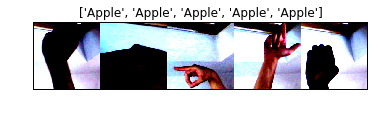

In [231]:
def imshow(inp, title=None):
    print(inp.shape)
    inp = inp.numpy().transpose((1,2,0))
    print(inp.shape)
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names_rnn[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders_rnn['Train']))
show_databatch(inputs, classes)

In [232]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return ( torch.from_numpy(np.eye(num_classes)[y]))

In [233]:
def embedd(word):
    x = torch.empty(5)
    c = 0
    vocab = {}
    for (index, letter) in enumerate(class_names):
        vocab[letter] = index
    word = word.upper() 
    word = word[:5]
    for i in word:
        x[c] = vocab[i]
        c += 1
    x = x.type(torch.LongTensor)    
    return x    

In [234]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [235]:
def trainRNN(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0
    chunk_len = 6
    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        value, index = torch.max(output.data, 1)
        loss += criterion(output, target[c].view((1)))
    print(loss)
    loss.backward()
    decoder_optimizer.step()

    return loss.data[0] / chunk_len

In [236]:
#model.eval()

In [237]:
n_epochs = 7
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005
n_characters = 29

for param in decoder.parameters():
    param.requires_grad = True
decoder = RNN(n_characters, hidden_size, 29, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0
m = model
for epoch in range(1, n_epochs + 1):
    print(epoch)
    for  (images, labels) in (dataloaders_rnn['Train']):
        show_databatch(images, labels)
        outputs = m(images)
        _, prediction = torch.max(outputs.data, 1)
        #print(prediction)
        space = torch.tensor([28])
        space.type(torch.LongTensor)
        cap_in = torch.cat((space,prediction))
        cap_out = torch.cat((embedd(class_names_rnn[labels[0]]),space))
        #print(cap_in)
        #print(cap_out)

        loss = trainRNN(cap_in, cap_out)       
        loss_avg += loss

        if epoch % print_every == 0:
            print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
            print(evaluate('Wh', 100), '\n')

        if epoch % plot_every == 0:
            all_losses.append(loss_avg / plot_every)
            loss_avg = 0

1
tensor(20.0294, grad_fn=<ThAddBackward>)


C:\Users\Shruti1992\Anaconda3\envs\cs682\lib\site-packages\ipykernel_launcher.py:14: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  


tensor(14.5891, grad_fn=<ThAddBackward>)
tensor(12.5022, grad_fn=<ThAddBackward>)
tensor(7.2976, grad_fn=<ThAddBackward>)
tensor(5.1262, grad_fn=<ThAddBackward>)
tensor(4.5496, grad_fn=<ThAddBackward>)
tensor(2.7192, grad_fn=<ThAddBackward>)
tensor(2.0373, grad_fn=<ThAddBackward>)
tensor(1.5120, grad_fn=<ThAddBackward>)
tensor(1.1208, grad_fn=<ThAddBackward>)
tensor(22.9908, grad_fn=<ThAddBackward>)
tensor(19.9075, grad_fn=<ThAddBackward>)
tensor(17.6012, grad_fn=<ThAddBackward>)
tensor(15.6580, grad_fn=<ThAddBackward>)
2
tensor(0.5670, grad_fn=<ThAddBackward>)
tensor(0.5200, grad_fn=<ThAddBackward>)
tensor(1.8856, grad_fn=<ThAddBackward>)
tensor(0.4592, grad_fn=<ThAddBackward>)
tensor(0.4444, grad_fn=<ThAddBackward>)
tensor(0.5066, grad_fn=<ThAddBackward>)
tensor(0.3739, grad_fn=<ThAddBackward>)
tensor(0.3329, grad_fn=<ThAddBackward>)
tensor(0.3011, grad_fn=<ThAddBackward>)
tensor(0.2783, grad_fn=<ThAddBackward>)
tensor(9.4044, grad_fn=<ThAddBackward>)
tensor(7.2773, grad_fn=<ThAddBac

In [238]:
def evaluate(inp):
    hidden = decoder.init_hidden()
    chunk_len = 6
    predicted = torch.zeros([chunk_len])
    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        value, index = torch.max(output.data, 1)
        predicted[c] = index
    return predicted

In [239]:
for param in decoder.parameters():
    param.requires_grad = False
for  (images, labels) in (dataloaders_rnn['Test']):
        outputs = m(images)
        _, prediction = torch.max(outputs.data, 1)
        print("CNN")
        print(prediction)
        space = torch.tensor([28])
        space.type(torch.LongTensor)
        cap_in = torch.cat((space,prediction))  
        p = evaluate(cap_in)
        print("RNN")
        print(p)

CNN
tensor([ 0, 15, 15, 11,  4])
RNN
tensor([ 0., 15., 15., 11.,  4., 28.])
CNN
tensor([ 0, 15, 15, 11,  0])
RNN
tensor([ 0., 15., 15., 11.,  4., 15.])
CNN
tensor([ 0, 15, 15, 11,  4])
RNN
tensor([ 0., 15., 15., 11.,  4., 28.])
CNN
tensor([ 0, 15, 15, 11,  4])
RNN
tensor([ 0., 15., 15., 11.,  4., 28.])
CNN
tensor([ 0, 15, 15, 11,  4])
RNN
tensor([ 0., 15., 15., 11.,  4., 28.])
CNN
tensor([ 0, 15, 26, 11,  4])
RNN
tensor([ 0., 15., 15.,  4.,  4., 28.])
CNN
tensor([ 0, 15, 15, 11,  3])
RNN
tensor([ 0., 15., 15., 11.,  4., 28.])
CNN
tensor([ 7, 14, 17, 18,  4])
RNN
tensor([ 0., 14., 17., 18.,  4., 28.])
CNN
tensor([ 7, 14, 21, 18,  4])
RNN
tensor([ 0., 14., 17., 17.,  4., 28.])
